In [164]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
from scipy.spatial import KDTree

In [165]:
pop_iris = gpd.read_file('pop_iris.gpkg')
jobs_iris = gpd.read_file('emplois_iris.gpkg')

In [166]:
zonage = gpd.read_file('zonage.geojson').to_crs('EPSG:3857')
zonage_serm = gpd.read_file('zoning_com_serm_2.gpkg').to_crs('EPSG:3857')

In [167]:
ods = pd.read_csv('od_serm_2.csv')

In [168]:
interesting_coms = list(zonage['insee_com'].unique())

In [169]:
pop_iris = pop_iris.loc[pop_iris['insee_com'].isin(interesting_coms)]
jobs_iris = jobs_iris.loc[jobs_iris['code_insee'].isin(interesting_coms)]

In [170]:
zones_decoup = {'63113': {'0': ['631132001', '631132002', '631132003', '631132101', '631132201', '631132202']
                          , '1': ['631130601', '631131801', '631131802', '631131803', '631131901', '631131902']
                          , '2': ['631130102', '631130201', '631130202', '631130602', '631130701', '631130802', '631131903', '631132301']
                          , '3': ['631132401', '631132501', '631130901', '631130902', '631131001', '631131101']
                          , '4': ['631130301', '631130302', '631130501', '631131601', '631131701', '631131702']
                          , '5': ['631130401', '631130402', '631130403']
                          , '6': ['631131201', '631131301', '631131404']
                          , '7': ['631131401', '631131405', '631131501', '631131502']}
                , '03118': {'0': ['031180102', '032550000']
                            , '1': ['031180101']}
                , '03310': {'0': ['033100101', '033100102', '033100103', '033100104', '033100105', '033100106']
                            , '1': ['033100107', '033100108', '033100109', '033100110']}
                , '63300': {'0': ['633000104', '633000101', '633000102', '633000103']
                            , '1': ['633000105', '633000110', '633000111', '633000109', '633000107', '633000108']}
                , '15187': {'0': ['151870101']
                            , '1': ['151870102']}
                , '42127': {'0': ['421270101']
                            , '1': ['421270102', '421270103']}
                , '42184': {'0': ['421840102', '421840106']
                            , '1': ['421840101', '421840103', '421840104', '421840105']}
                , '42187': {'0': ['421870501', '421870601']
                            , '1': ['421870301', '421870302', '421870303', '421870401', '421870602']
                            , '2': ['421870101', '421870201', '421870202', '421870701', '421870702']
                            , '3': ['421870801', '421870802', '421870901', '421871001']}
                }

correct_dic = {'031180102': '03118_0'
               , '032550000': '03118_0'
               , '031180101': '03118_1'
               , '421840101': '42127_1'}

In [171]:
def apply_revert_index(row, code_col):
    if row[code_col] not in zones_decoup.keys():
        return row[code_col]
    else:
        for x, iris_codes in zones_decoup[row[code_col]].items():
            if row['code_iris'] in iris_codes:
                return row[code_col] + '_' + x

In [172]:
jobs_iris

,gml_id,lowercorner,uppercorner,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,area,jobs_min,jobs_med,jobs_max,d_jobs_min,d_jobs_med,d_jobs_max,geometry
99,contours_iris.100,45.78109057 3.08668428,45.79969185 3.11259845,IRIS____0000000631130102,63113,Clermont-Ferrand,0102,631130102,Îlot 1er Mai,A,1.130169,3102.0,4588.0,6074.0,1332.491250,1970.815556,2609.139862,"MULTIPOLYGON (((344094.754 5745345.646, 344094..."
100,contours_iris.101,46.04907614 4.02895791,46.0671134 4.05396955,IRIS____0000000421840102,42184,Riorges,0102,421840102,La Villette,A,1.723137,1585.0,2398.0,3211.0,442.219736,669.049165,895.878594,"MULTIPOLYGON (((448501.543 5790768.795, 448517..."
122,contours_iris.123,45.77276278 3.16228194,45.78869603 3.22179568,IRIS____0000000631930102,63193,Lempdes,0102,631930102,Zone d'Activités,A,5.382592,2459.0,3629.0,4799.0,221.851122,327.408589,432.966056,"MULTIPOLYGON (((352025.785 5744879.547, 352341..."
149,contours_iris.150,45.73970163 3.12743184,45.76092585 3.15411437,IRIS____0000000630140103,63014,Aubière,0103,630140103,Secteur d'Activités Économiques,A,2.602477,4073.0,6071.0,8069.0,760.814283,1134.029834,1507.245385,"MULTIPOLYGON (((351004.266 5738912.367, 350599..."
213,contours_iris.214,45.72096615 3.14998259,45.75569299 3.18440751,IRIS____0000000631240104,63124,Cournon-d'Auvergne,0104,631240104,Zone d'Activités,A,5.156545,4754.0,7135.0,9516.0,448.395529,672.970572,897.545614,"MULTIPOLYGON (((352962.681 5735832.977, 352890..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48169,contours_iris.48170,45.75553556 3.65247587,45.81337167 3.73889191,IRIS____0000000634680000,63468,Vollore-Montagne,0000,634680000,Vollore-Montagne,Z,21.147126,0.0,0.0,0.0,0.000000,0.000000,0.000000,"MULTIPOLYGON (((415567.943 5742281.508, 415553..."
48170,contours_iris.48171,45.75837051 3.55983313,45.8125035 3.65860965,IRIS____0000000634690000,63469,Vollore-Ville,0000,634690000,Vollore-Ville,Z,30.520698,12.0,16.5,21.0,0.190907,0.262497,0.334087,"MULTIPOLYGON (((396278.811 5745870.568, 396343..."
48179,contours_iris.48180,45.83406665 2.97729781,45.89535297 3.06494753,IRIS____0000000634700000,63470,Volvic,0000,634700000,Volvic,Z,27.661226,379.0,560.5,742.0,6.632673,9.809005,12.985338,"MULTIPOLYGON (((331579.043 5755100.446, 331548..."
48509,contours_iris.48510,45.58904928 3.21749344,45.62897781 3.29567159,IRIS____0000000634720000,63472,Yronde-et-Buron,0000,634720000,Yronde-et-Buron,Z,14.672065,5.0,7.0,9.0,0.166509,0.233113,0.299717,"MULTIPOLYGON (((365761.107 5720557.144, 365735..."


In [173]:
jobs_iris = jobs_iris[['code_insee', 'nom_commune', 'code_iris', 'jobs_med', 'area', 'geometry']]
pop_iris = pop_iris[['insee_com', 'nom_com', 'code_iris', 'pop', 'area', 'geometry']]

In [174]:
jobs_iris['code_zone_serm'] = jobs_iris.apply(apply_revert_index, code_col='code_insee', axis=1)
pop_iris['code_zone_serm'] = pop_iris.apply(apply_revert_index, code_col='insee_com', axis=1)

c:\Users\lrapin\AppData\Local\miniforge3\envs\gpseo_env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [175]:
jobs_iris.loc[jobs_iris['code_iris'].isin(correct_dic.keys()), 'code_zone_serm'] = jobs_iris.loc[jobs_iris['code_iris'].isin(correct_dic.keys()), 'code_iris'].map(correct_dic)
pop_iris.loc[pop_iris['code_iris'].isin(correct_dic.keys()), 'code_zone_serm'] = pop_iris.loc[pop_iris['code_iris'].isin(correct_dic.keys()), 'code_iris'].map(correct_dic)

In [176]:
jobs_iris = jobs_iris.groupby('code_zone_serm')[['jobs_med', 'area', 'geometry', 'nom_commune']].agg({'jobs_med': np.nansum
                                                                                       , 'area': np.nansum
                                                                                       , 'geometry': shapely.unary_union
                                                                                       , 'nom_commune': 'first'})

C:\Users\lrapin\AppData\Local\Temp\ipykernel_30260\46346139.py:1: FutureWarning: The provided callable <function nansum at 0x000002832D38EFC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  jobs_iris = jobs_iris.groupby('code_zone_serm')[['jobs_med', 'area', 'geometry', 'nom_commune']].agg({'jobs_med': np.nansum
C:\Users\lrapin\AppData\Local\Temp\ipykernel_30260\46346139.py:1: FutureWarning: The provided callable <function nansum at 0x000002832D38EFC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  jobs_iris = jobs_iris.groupby('code_zone_serm')[['jobs_med', 'area', 'geometry', 'nom_commune']].agg({'jobs_med': np.nansum


In [177]:
pop_iris = pop_iris.groupby(['code_zone_serm'])[['pop', 'area', 'geometry', 'nom_com']].agg({'pop': np.nansum
                                                                                       , 'area': np.nansum
                                                                                       , 'geometry': shapely.unary_union
                                                                                       , 'nom_com': 'first'})

C:\Users\lrapin\AppData\Local\Temp\ipykernel_30260\2524832965.py:1: FutureWarning: The provided callable <function nansum at 0x000002832D38EFC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pop_iris = pop_iris.groupby(['code_zone_serm'])[['pop', 'area', 'geometry', 'nom_com']].agg({'pop': np.nansum
C:\Users\lrapin\AppData\Local\Temp\ipykernel_30260\2524832965.py:1: FutureWarning: The provided callable <function nansum at 0x000002832D38EFC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pop_iris = pop_iris.groupby(['code_zone_serm'])[['pop', 'area', 'geometry', 'nom_com']].agg({'pop': np.nansum


In [178]:
jobs_iris.reset_index(inplace=True)
pop_iris.reset_index(inplace=True)

In [179]:
serm_zones = pop_iris.copy()[['code_zone_serm', 'geometry']]
serm_zones['geometry'] = serm_zones['geometry'].apply(shapely.centroid)

In [180]:
serm_zones = gpd.GeoDataFrame(serm_zones, geometry='geometry', crs='EPSG:3857')

In [181]:
zonage_serm['geometry'] = zonage_serm['geometry'].apply(shapely.centroid)

In [182]:
#serm_zones.to_file('serm_zones.gpkg')
#zonage_serm.to_file('zonage_serm.gpkg')

In [183]:
serm_zones_centroids = np.array(serm_zones['geometry'].apply(lambda x: [x.x, x.y]).values.tolist())
zonage_serm_points = np.array(zonage_serm['geometry'].apply(lambda x: [x.x, x.y]).values.tolist())

tree = KDTree(serm_zones_centroids)
distances, indices = tree.query(zonage_serm_points, k = 1)

In [184]:
zone_ids = zonage_serm['new_zone_id'].values.tolist()
iris_ids = serm_zones['code_zone_serm'].values.tolist() 

In [185]:
serm_zones_dic = serm_zones['code_zone_serm'].to_dict()
zonage_serm_dic = zonage_serm['new_zone_id'].to_dict()

In [186]:
zonage_serm.reset_index(names='index_num', inplace=True)

In [187]:
zonage_serm['iris_id'] = zonage_serm['index_num'].apply(lambda x: serm_zones_dic[indices[x]])

In [188]:
dic_zones = zonage_serm.set_index('new_zone_id')['iris_id'].to_dict()

In [189]:
zonage_final = gpd.read_file('zoning_com_serm_2.gpkg').to_crs('EPSG:3857')
zonage_final['iris_id'] = zonage_final['new_zone_id'].map(dic_zones)

In [190]:
zonage_final.set_index('iris_id', inplace=True)

In [191]:
pop_iris.set_index('code_zone_serm', inplace=True)
jobs_iris.set_index('code_zone_serm', inplace=True)

In [192]:
zonage_final = zonage_final.merge(pop_iris[['pop', 'nom_com']], left_index=True, right_index=True, how='left')
zonage_final = zonage_final.merge(jobs_iris['jobs_med'], left_index=True, right_index=True, how='left')

In [193]:
zonage_final['pop'] = zonage_final['pop'].apply(np.round, decimals=0)
zonage_final['jobs_med'] = zonage_final['jobs_med'].apply(np.round, decimals=0)

In [194]:
zonage_final.reset_index(inplace=True)

In [195]:
zonage_final['area'] = zonage_final.to_crs('EPSG:2154').area/10**6
zonage_final.rename(columns={'pop': 'population'}, inplace=True)
zonage_final.rename(columns={'jobs_med': 'emplois'}, inplace=True)

zonage_final['density_population'] = zonage_final['population']/zonage_final['area']
zonage_final['density_emplois'] = zonage_final['emplois']/zonage_final['area']

In [196]:
zonage_final

,iris_id,new_zone_id,geometry,population,nom_com,emplois,area,density_population,density_emplois
0,03001,0,"MULTIPOLYGON (((380899.234 5794871.273, 380893...",2919.0,Abrest,802.0,10.321566,282.805913,77.701385
1,03004,1,"MULTIPOLYGON (((411780.016 5822023.015, 411886...",229.0,Andelaroche,2.0,20.316362,11.271703,0.098443
2,03006,2,"MULTIPOLYGON (((416364.145 5811586.812, 416387...",625.0,Arfeuilles,26.0,59.492100,10.505597,0.437033
3,03008,3,"MULTIPOLYGON (((393804.542 5794332.704, 393837...",379.0,Arronnes,4.0,26.010466,14.571058,0.153784
4,03014,4,"MULTIPOLYGON (((444649.655 5833012.497, 444839...",136.0,Avrilly,0.0,11.488961,11.837450,0.000000
...,...,...,...,...,...,...,...,...,...
893,63113_3,1215,"MULTIPOLYGON Z (((348278.689 5741529.735 0, 34...",19797.0,Clermont-Ferrand,31753.0,21.253847,931.454914,1493.988377
894,63430,1216,"MULTIPOLYGON Z (((396658.294 5754107.62 0, 396...",11633.0,Thiers,4926.0,44.953702,258.777351,109.579406
895,63075,1217,"MULTIPOLYGON Z (((341771.955 5742746.629 0, 34...",17454.0,Chamalières,4618.0,3.803454,4588.986495,1214.159484
896,63164,1218,"MULTIPOLYGON Z (((351060.165 5750026.905 0, 35...",10258.0,Gerzat,3507.0,16.548857,619.861534,211.917957


In [197]:
zonage_final.to_file('zonage_final.geojson')

In [198]:
zonage_final['nb_polygons'] = zonage_final['geometry'].apply(lambda x: len(x.geoms))

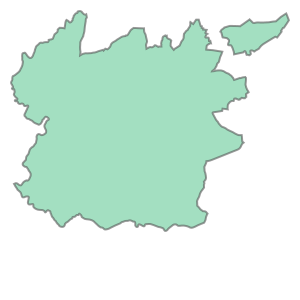

In [201]:
zonage_final.loc[zonage_final['nb_polygons'] != 1, 'geometry'].values.tolist()[0]

In [204]:
zonage_final['geometry'] = zonage_final['geometry'].apply(lambda x: shapely.geometry.MultiPolygon(x))

In [206]:
def drop_z(geom):
    return shapely.ops.transform(lambda x, y, z=None: (x, y), geom)

In [207]:
zonage_final['geometry'] = zonage_final['geometry'].apply(drop_z)

In [210]:
zonage_final

,iris_id,new_zone_id,geometry,population,nom_com,emplois,area,density_population,density_emplois,nb_polygons
0,03001,0,"MULTIPOLYGON (((380899.234 5794871.273, 380893...",2919.0,Abrest,802.0,10.321566,282.805913,77.701385,1
1,03004,1,"MULTIPOLYGON (((411780.016 5822023.015, 411886...",229.0,Andelaroche,2.0,20.316362,11.271703,0.098443,1
2,03006,2,"MULTIPOLYGON (((416364.145 5811586.812, 416387...",625.0,Arfeuilles,26.0,59.492100,10.505597,0.437033,1
3,03008,3,"MULTIPOLYGON (((393804.542 5794332.704, 393837...",379.0,Arronnes,4.0,26.010466,14.571058,0.153784,1
4,03014,4,"MULTIPOLYGON (((444649.655 5833012.497, 444839...",136.0,Avrilly,0.0,11.488961,11.837450,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
893,63113_3,1215,"MULTIPOLYGON (((348278.689 5741529.735, 348254...",19797.0,Clermont-Ferrand,31753.0,21.253847,931.454914,1493.988377,1
894,63430,1216,"MULTIPOLYGON (((396658.294 5754107.62, 396645....",11633.0,Thiers,4926.0,44.953702,258.777351,109.579406,1
895,63075,1217,"MULTIPOLYGON (((341771.955 5742746.629, 341766...",17454.0,Chamalières,4618.0,3.803454,4588.986495,1214.159484,1
896,63164,1218,"MULTIPOLYGON (((351060.165 5750026.905, 351060...",10258.0,Gerzat,3507.0,16.548857,619.861534,211.917957,1


In [211]:
zonage_final.rename(columns={'density_population': 'density', 'density_emplois': 'emplois_density'}, inplace=True)

In [213]:
zonage_final.to_file('zonage.geojson')

Ajouter les différents modes: